<a href="https://colab.research.google.com/github/PyBlin/Study/blob/main/PyML/Chapter3_Evaluation/Chap3_5_ROC_AUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.ROC Curve & AUC

* ROC( Receiver Operation Characteristic ) Curve : 수신자 판단 곡선
* X축 : FPR( False Positive Rate )
>* FPR = FP / (FP + TN)
* Y축 : TPR( True Positive Rate ) --> Recall or Sensitivity
* Sensitivity(민감도) vs Specificity(특이성)
>* 민감도(TPR) : 실제 Positive가 정확히 예측돼야 하는 수준
>>* 질병이 있는 사람은 질병이 있는 것으로 양성 판정
>* 특이성(TNR) : 실제 Negative가 정확히 예측돼야 하는 수준
>>* TNR = TN / (FP + TN)
>>* FPR = 1 - TNR

* ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화값을 구합니다.
>* 임계값=1 --> FPR=0
>* 임계값=0 --> FPR=1

In [1]:
# transform_features() 생성

from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def titanic_fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# ML 알고리즘에 불필요한 속성 제거
def titanic_drop(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# label encoding
def titanic_le(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 위에서 설정한 데이터 전처리 함수 종합
def transform_features(df):
    df = titanic_fillna(df)
    df = titanic_drop(df)
    df = titanic_le(df)
    return df

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터 로딩, 데이터 가공, 학습/테스트 데이터 분할
titanic_df = pd.read_csv('./train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

# transform_features() 설정 필요
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size=0.2, 
                                                    random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

pred_proba = lr_clf.predict_proba(X_test)

* `roc_curve()` API를 이용해 FPR, TPR, 임계값을 구해봅시다!

In [3]:
from sklearn.metrics import roc_curve
import numpy as np

# 레이블 값이 1일 때의 예측 확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되 5 Step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정되므로, 
# 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print(f"샘플 추출을 위한 임계값 배열의 인덱스 : {thr_index}")
print(f"샘플 인덱스로 추출한 임계값 : {np.round(thresholds[thr_index], 2)}")

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print(f"\n샘플 임계값별 FPR : {np.round(fprs[thr_index], 3)}")
print(f"샘플 임계값별 TPR : {np.round(tprs[thr_index], 3)}")

샘플 추출을 위한 임계값 배열의 인덱스 : [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 인덱스로 추출한 임계값 : [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]

샘플 임계값별 FPR : [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값별 TPR : [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


* 임계값이 1부터 점점 작아지면서 FPR이 점점 커집니다.
* FPR이 조금씩 커질 때 TPR은 가파르게 커집니다.
* 이제 시각화로 표현해 봅시다!

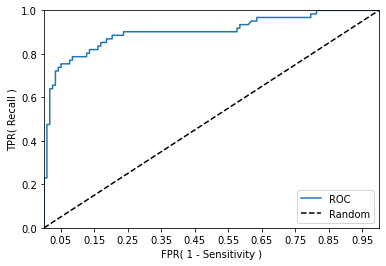

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR 값을 반환
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선
    plt.plot(fprs, tprs, label='ROC')

    # 가운데 대각선 직선
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X축의 스케일을 0.1 단위로 변경 및 축 이름 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

* ROC 곡선 자체는 FPR, TPR의 변화를 보는 용도입니다.
* 분류의 성능 지표로 사용되는 것은 AUC 입니다.
>* Area Under Curve
>* ROC 곡선 밑의 면적으로 1에 가까울 수록 좋습니다.
>* AUC를 높이려면 FPR이 작을 때 TPR을 크게 얻어야 합니다.
>* 가운데 직선은 랜덤 수준의 이진 분류 AUC 값으로 0.5 입니다.
>* 따라서 보통의 분류는 0.5 이상의 AUC 값입니다.

In [5]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f"ROC AUC value : {roc_score:.4f}")

ROC AUC value : 0.9024


* 타이타닉 생존자 예측 Logistic Regression 모델의 AUC 값은 0.9024 입니다.
* 이제 `get_clf_eval()`에 `roc_auc_score()`를 추가해 봅시다!
* AUC는 예측 확률값을 기반으로 계산되므로
>* `get_clf_eval(y_test, pred=None, pred_proba=None)`로 변경합니다.

In [6]:
# 평가를 한번에 호출하는 get_clf_eval() 함수 생성
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
confusion_matrix

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)

    print(f"Confusion Matrix : \n{confusion}")
    print(f"\nAccuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"ROC AUC   : {roc_auc:.4f}")

In [7]:
from sklearn.preprocessing import Binarizer

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 반복하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('-'*30)
        print(f"임계값 : {custom_threshold}")
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

IndexError: ignored